#### SNNのFeedForwardの実装
- 最終的な式は
$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{S[t]U_{\rm thr}}_\text{reset} $$ 

1. W : 入力に対する重みで学習可能
1. S : 発火した時にリセットする項
1. β : 遅延度合い

In [2]:
import torch
import matplotlib.pyplot as plt

from snntorch import spikeplot as splt 

In [3]:
# def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
#   # Generate Plots
#   fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
#                         gridspec_kw = {'height_ratios': [1, 1, 0.4]})

#   # Plot input current
#   ax[0].plot(cur, c="tab:orange")
#   ax[0].set_ylim([0, ylim_max1])
#   ax[0].set_xlim([0, 200])
#   ax[0].set_ylabel("Input Current ($I_{in}$)")
#   if title:
#     ax[0].set_title(title)

#   # Plot membrane potential
#   ax[1].plot(mem)
#   ax[1].set_ylim([0, ylim_max2]) 
#   ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
#   if thr_line:
#     ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
#   plt.xlabel("Time step")

#   # Plot output spike using spikeplot
#   splt.raster(spk, ax[2], s=400, c="black", marker="|")
#   if vline:
#     ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
#   plt.ylabel("Output spikes")
#   plt.yticks([]) 

#   plt.show()

In [4]:
def leaky_integrate_and_fire(mem,x,w,beta,threshold=1):
    spk=(mem > threshold)
    mem=beta*mem + w*x - spk*threshold
    return spk,mem

#### βの値の設定

- 以下の２式から値が確定する
$$U(t) = U_0e^{-\frac{t}{\tau}}$$
$$\beta = \frac{U_0e^{-\frac{t+\Delta t}{\tau}}}{U_0e^{-\frac{t}{\tau}}} = \frac{U_0e^{-\frac{t + 2\Delta t}{\tau}}}{U_0e^{-\frac{t+\Delta t}{\tau}}} =~~...$$
$$\implies \beta = e^{-\frac{\Delta t}{\tau}} $$


In [5]:
delta_t=torch.tensor(1e-3)
tau=torch.tensor(5e-3)
beta=torch.exp(-delta_t/tau)

print(f'遅延率は : {beta:.3f}')


遅延率は : 0.819


In [10]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

# plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,
#                  title="LIF Neuron Model With Weighted Step Voltage")

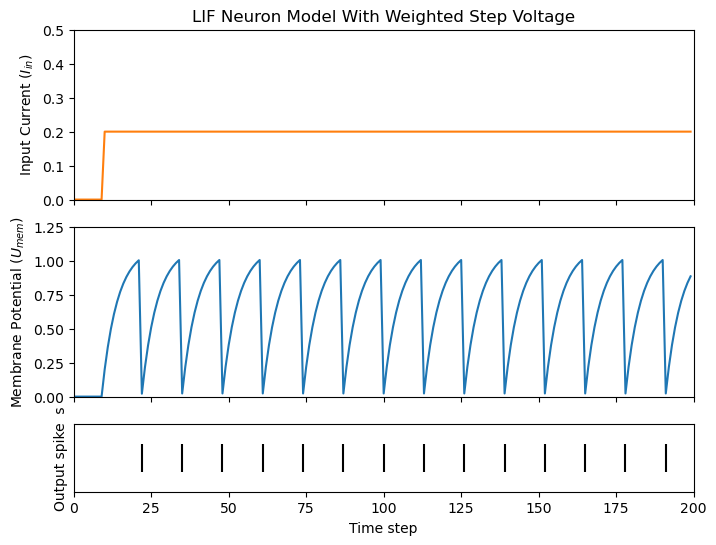

In [9]:
class SNN_input:
    def __init__(self,x,w,mem,delta,tau,threshold,spk_out,num_step=200):
        self.x=x
        self.w=w
        self.mem=mem
        self.spk_out=spk_out
        self.delta=delta
        self.tau=tau
        self.threshold=threshold
        self.num_step=num_step
        self.mem_rec=[]
        self.spk_rec=[]

    def calculate_beta(self):
        beta=torch.exp(-self.delta/self.tau)
        return beta

    def leaky_integrate_and_fire(self,x):
        self.spk=(self.mem > self.threshold)
        self.mem=self.calculate_beta()*self.mem + self.w*x - self.spk*self.threshold
        return self.spk,self.mem
    
    def neuron_simulation(self):
        for step in range(self.num_step):
            self.spk,self.mem=self.leaky_integrate_and_fire(self.x[step])
            self.mem_rec.append(self.mem)
            self.spk_rec.append(self.spk)

    def plot_cur_mem_spk(self,title=False,save=False,path=None,
                        ylim_max1=1.25,ylim_max2=1.25):

        mem_rec = torch.stack(self.mem_rec)
        spk_rec = torch.stack(self.spk_rec)
        fig,ax=plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})
        
        ax[0].plot(self.x*self.w,c='tab:orange')
        ax[0].set_ylim([0, ylim_max1])
        ax[0].set_xlim([0, self.num_step])
        ax[0].set_ylabel("Input Current ($I_{in}$)")
        if title:
            ax[0].set_title(title)

        ax[1].plot(mem_rec)
        ax[1].set_ylim([0, ylim_max2]) 
        ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
        plt.xlabel("Time step")

        splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
        plt.ylabel("Output spike  s")
        plt.yticks([]) 
        if save:
            plt.savefig(path)
        plt.show()

        
mem_rec=SNN_input(x=torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0),
                w=0.4,
                mem=torch.zeros(1),
                spk_out= torch.zeros(1),
                delta=torch.tensor(1e-3),
                tau=torch.tensor(5e-3),
                threshold=1)

mem_rec.neuron_simulation()
mem_rec.plot_cur_mem_spk(title='LIF Neuron Model With Weighted Step Voltage' ,
                        save=True,
                        path='Images/LIF_Neuron_Step_Voltage.png',
                        ylim_max1=0.5)

In [ ]:
class forward(SNN_input):
    def __init__(self,num_inputs,num_hidden,num_outputs):#初期化したい変数
        super().__init__(delta,tau)#親クラスの変数

